# About: CoursewareHub用VMをAWSに作成

----

CoursewareHub用として Amazon&nbsp;EC2インスタンスを確保します。 VPCなどのリソースを合わせて確保するため、CloudFormationを使用しています。


本Notebookでは、以下のようなVMを構築します。

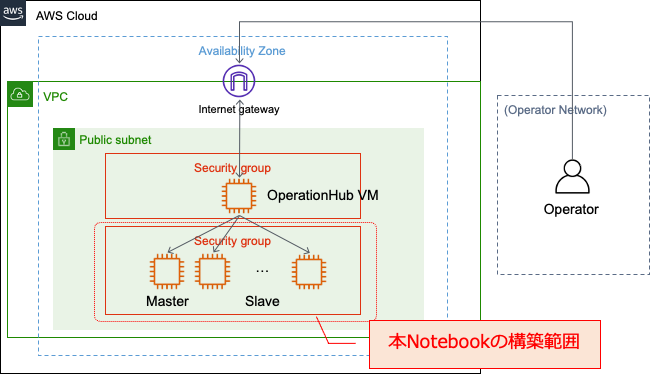

* 本Notebookを試すには、 [D01_OperationHubをAWSに構築.ipynb](https://github.com/NII-cloud-operation/CoursewareHub-LC_deploy/blob/master/D01_OperationHub%E3%82%92AWS%E3%81%AB%E6%A7%8B%E7%AF%89.ipynb) で作成されたOperationHub環境にNotebook一式をコピーし、実行してください。
* 本Notebookを試すには、AWSのアカウントが必要です。AWSにてクレジットカード等の登録が必要な場合があります。
* t2.mediumインスタンス(2 vCPU, RAM 4GB)を複数台使用します(台数はNotebookによりカスタマイズ可能)。使用にはAWSの料金がかかります。料金等はあらかじめ https://aws.amazon.com/jp/ec2/instance-types/t2/ で確認の上、ご自身の責任でお試しください。

# 事前条件

**事前にTerminalから、 `aws configure` を実施してください。**

`aws configure` の実施例:

```
$ aws configure
AWS Access Key ID [None]: (自身のアカウントのアクセスキー)
AWS Secret Access Key [None]: (自身のアカウントのシークレットアクセスキー)
Default region name [None]: ap-northeast-1 (使用したいリージョン)
Default output format [None]: json (jsonを指定)
```

アクセスキー管理方法は様々ありますが、AWS IAMのユーザー https://console.aws.amazon.com/iam/home?region=us-west-2#/users からNotebook用のユーザーを作成する方法があります。万が一アクセスキーが漏れた場合に備えて、権限を最小限に、いつでも無効化できるように設定する必要があります。

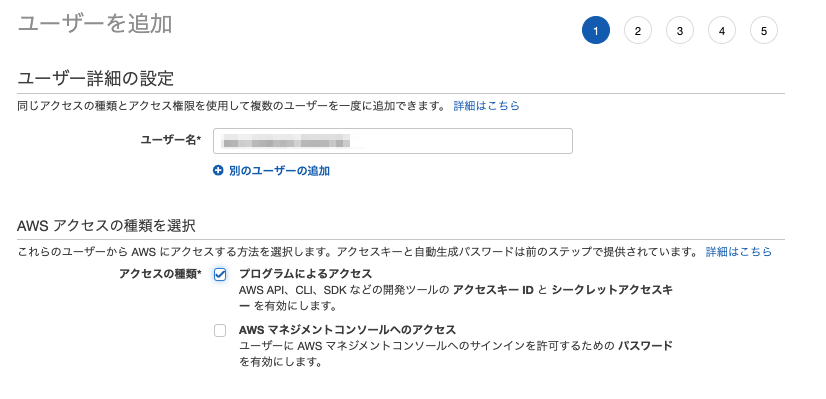

権限は `AmazonEC2FullAccess` と `AWSCloudFormationFullAccess` を想定しています。

正しくアクセス情報が指定されているかどうかを、`describe-vpcs`により確認します。**以下のコマンド実行がエラーとなる場合、`aws configure`が正しくなされていない可能性があります。**

In [ ]:
import json
import sys

vpc_result = !aws ec2 describe-vpcs
try:
    vpcs = json.loads('\n'.join(vpc_result))['Vpcs']
    print('{} VPCs exist'.format(len(vpcs)))
except:
    print(vpc_result)
    raise sys.exc_info()

# リソースの定義



## 設置先VPC, Subnetの情報

本Notebookは、OperationHubが収容されているVPCに対して操作を行います。

> cloudformation-stack.jsonは `D01_OperationHubをAWSに構築.ipynb` により作成されます。

In [ ]:
!ls -la ~/cloudformation-stack.json

In [ ]:
import os
with open(os.path.expanduser('~/cloudformation-stack.json'), 'rb') as f:
    cloudformation_stack = dict([(o['OutputKey'], o['OutputValue']) for o in json.load(f)])
cloudformation_stack

本Notebookを実行するには、VPC, Subnet, 接続元Security Groupを指定する必要があります。

In [ ]:
vpc_id = cloudformation_stack['OpHubVPC']
subnet_id = cloudformation_stack['OpHubSubnet']
from_sg_id = cloudformation_stack['OpHubSecurityGroup']
(vpc_id, subnet_id, from_sg_id)

また、CloudFormationを利用してVPCやその他のリソースの準備を行います。CloudFormationのStackを1つ作成しますので、**本VMが不要になったら削除**してください。

In [ ]:
stacks_result = !aws cloudformation list-stacks
try:
    stacks = json.loads('\n'.join(stacks_result))['StackSummaries']
    print('{} Stacks exist'.format(len(stacks)))
except:
    print(stacks_result)
    raise sys.exc_info()

## CloudFormationのStack名

本Notebookが作成するリソースを管理するための CloudFormationのスタック名を設定してください。

In [ ]:
cloudformation_stack_name = 'cwhtest0001'
cloudformation_stack_name

## イメージのID

イメージは CentOS 7を前提とする。

In [ ]:
# CentOS 7
# ap-northeast-1を使用する場合
image_id = 'ami-06a46da680048c8ae'
# us-west-2 (オレゴン) を使用する場合
#image_id = 'ami-0bc06212a56393ee1'

## Keypairの準備

使用するキーペア名を設定します。

In [ ]:
resource_prefix = 'cwhtest0001'
resource_prefix

## 仮想マシンのパラメータ設定

仮想マシンの構成情報を設定する。

In [ ]:
master_instance_type = 't2.medium'
slave_instance_type = 't2.medium'
slave_instances = 2
master_volume_size = 100
slave_volume_size = 50
(master_instance_type, slave_instance_type, slave_instances, master_volume_size, slave_volume_size)

以下のセルは、誤ってRun Allでまとめ実行した際に先に進まないように設定しています。
これまでのセル実行が問題なければ、以下のコードセルを選択してFreezeボタンを押してFreezeして先に進めてください。

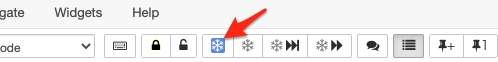

In [ ]:
# ここまでのパラメータを確認したら本セルはFreezeして先に進める。
assert False

In [ ]:
hostname = !hostname
keypair_name = '{}-{}'.format(resource_prefix, hostname[0])
keypair_name

本Notebookはインスタンスとの接続のために、 `~/.ssh/ansible_id_rsa` と言う名前の秘密鍵ファイルを生成します。
Notebook環境の `/home/jovyan` をホストディレクトリにマウントするなどして永続化していないと、この秘密鍵もコンテナの削除とともに消えますのでご注意ください。

> デモ用途なのでPassphraseなしで作っています。実際にはPassphraseをつけて、ssh-agentで鍵の取り回しをしています。

In [ ]:
import os
ssh_keypath = os.path.expanduser('~/.ssh')
if not os.path.exists(os.path.join(ssh_keypath, 'ansible_id_rsa')):
    !ssh-keygen -t rsa -b 2048 -C ansible -f {ssh_keypath}/ansible_id_rsa -P ''
!cat {ssh_keypath}/ansible_id_rsa.pub

現在のキーの一覧を確認しておきます。

In [ ]:
import json
result = !aws ec2 describe-key-pairs
keypairs = json.loads('\n'.join(result))['KeyPairs']
print('{} keys'.format(len(keypairs)))

本Notebookは設定された resource_prefix 変数と hostname を使ってキーペア名を決定します。同一名称のキーペア名があれば特に何もしません。

In [ ]:
if keypair_name not in [k['KeyName'] for k in keypairs]:
    !aws ec2 import-key-pair --key-name {keypair_name} --public-key-material file://{ssh_keypath}/ansible_id_rsa.pub

# CloudFormation Stack作成

VMを構築するためのCloudFormation Templateを作成し、CloudFormationで実行します。

## Templateの定義

In [ ]:
import tempfile
work_dir = tempfile.mkdtemp()
work_dir

In [ ]:
with open(os.path.join(work_dir, 'template.yml'), 'w') as f:
    slave_instance_defs = ''.join(['''
  CwHubSlaveInstance{n}:
    Type: "AWS::EC2::Instance"
    Properties: 
      ImageId: !Ref ImageId
      InstanceType: !Ref SlaveInstanceType
      KeyName: !Ref KeyName
      NetworkInterfaces:
        - AssociatePublicIpAddress: true
          DeviceIndex: 0
          GroupSet:
          - !Ref CwHubSecurityGroup
          SubnetId: !Ref OpHubSubnet
      Tags:
      - Key: Name
        Value: !Sub ${{AWS::StackName}}-CwHub-Slave{n}
      BlockDeviceMappings:
        - DeviceName: /dev/sda1
          Ebs:
            VolumeSize: !Ref SlaveVolumeSizeGB
            DeleteOnTermination: true
'''.format(n=i + 1) for i in range(slave_instances)])
    slave_instance_ids = ''.join(['''
  CwHubSlaveInstanceId{n}:
    Value: !Ref CwHubSlaveInstance{n}
    
  CwHubSlavePrivateIp{n}:
    Value: !GetAtt CwHubSlaveInstance{n}.PrivateIp

'''.format(n=i + 1) for i in range(slave_instances)])
    
    f.write(f'''
AWSTemplateFormatVersion: "2010-09-09"
Description: 'A template for CoursewareHub'
Parameters:
  KeyName:
    Type: String

  ImageId:
    Type: String

  OpHubVPC:
    Type: String

  OpHubSubnet:
    Type: String

  MasterInstanceType:
    Type: String

  SlaveInstanceType:
    Type: String

  FromSecurityGroup:
    Type: String

  MasterVolumeSizeGB:
    Type: Number

  SlaveVolumeSizeGB:
    Type: Number

Resources:
  CwHubSecurityGroup:
    Type: AWS::EC2::SecurityGroup
    Properties:
      GroupDescription: security group for CoursewareHub
      VpcId: !Ref OpHubVPC
      SecurityGroupIngress:
        - SourceSecurityGroupId: !Ref FromSecurityGroup
          IpProtocol: -1
      Tags:
      - Key: Name
        Value: !Sub ${{AWS::StackName}}-CwHubSG

  CwHubEIP:
    Type: AWS::EC2::EIP
    Properties:
      InstanceId: !Ref CwHubMasterInstance

  CwHubMasterInstance:
    Type: "AWS::EC2::Instance"
    Properties: 
      ImageId: !Ref ImageId
      InstanceType: !Ref MasterInstanceType
      KeyName: !Ref KeyName
      NetworkInterfaces:
        - AssociatePublicIpAddress: true
          DeviceIndex: 0
          GroupSet:
          - !Ref CwHubSecurityGroup
          SubnetId: !Ref OpHubSubnet
      Tags:
      - Key: Name
        Value: !Sub ${{AWS::StackName}}-CwHub-Master
      BlockDeviceMappings:
        - DeviceName: /dev/sda1
          Ebs:
            VolumeSize: !Ref MasterVolumeSizeGB
            DeleteOnTermination: true

{slave_instance_defs}

Outputs:
  CwHubMasterInstanceId:
    Value: !Ref CwHubMasterInstance
    
  CwHubMasterPrivateIp:
    Value: !GetAtt CwHubMasterInstance.PrivateIp

{slave_instance_ids}

  CwHubIP:
    Value: !Ref CwHubEIP

  CwHubSecurityGroup:
    Value: !Ref CwHubSecurityGroup
''')
!cat {work_dir}/template.yml

## Stackの作成

Cloud FormationのStackを作成します。

In [ ]:
stack_result = !aws cloudformation create-stack --stack-name {cloudformation_stack_name} \
    --parameters ParameterKey=KeyName,ParameterValue={keypair_name} ParameterKey=ImageId,ParameterValue={image_id} \
    ParameterKey=OpHubVPC,ParameterValue={vpc_id} ParameterKey=OpHubSubnet,ParameterValue={subnet_id} \
    ParameterKey=MasterInstanceType,ParameterValue={master_instance_type} ParameterKey=SlaveInstanceType,ParameterValue={slave_instance_type} \
    ParameterKey=MasterVolumeSizeGB,ParameterValue={master_volume_size} ParameterKey=SlaveVolumeSizeGB,ParameterValue={slave_volume_size} \
    ParameterKey=FromSecurityGroup,ParameterValue={from_sg_id} \
    --template-body file://{work_dir}/template.yml
try:
    stack_id = json.loads('\n'.join(stack_result))['StackId']
    print('StackId', stack_id)
except:
    print(stack_result)
    raise sys.exc_info()

以下のセルの実行結果に表示されるURLをクリックして、作成状況を確認してください。ステータスがCREATE_COMPLETEとなれば、Stackの作成は成功です。

In [ ]:
import urllib.parse
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/cloudformation/home#/stacks/stackinfo?stackId={stack_id}'.format(region=regions[0], stack_id=urllib.parse.quote(stack_id)))

**ステータスがCREATE_COMPLETEに変化したことを確認**したら、以下のセルを実行してください。

> 以下のセルは、Stack作成中の場合はエラーとなります。

In [ ]:
describe_stack_result = !aws cloudformation describe-stacks --stack-name {stack_id}
stack_desc = json.loads(''.join(describe_stack_result))['Stacks'][0]
assert stack_desc['StackStatus'] == 'CREATE_COMPLETE', stack_desc['StackStatus']

## Security Groupの変更

CloudFormationにより、VMインスタンスが起動したようなので、Notebook環境から疎通確認をする。VMインスタンスのSecurity Groupは**デフォルトではどこからも接続を受け入れないようにしている**ので以下のURLから設定変更する。

AnsibleでのVM操作にはSSH(TCPポート22)を使用する。このJupyter Notebook環境からVMへのSSHアクセスを許可するよう適切なポートおよびアクセス元IPアドレスを指定する。**インバウンドルールを編集**ボタンを選択して、以下のようなルールを追加する。

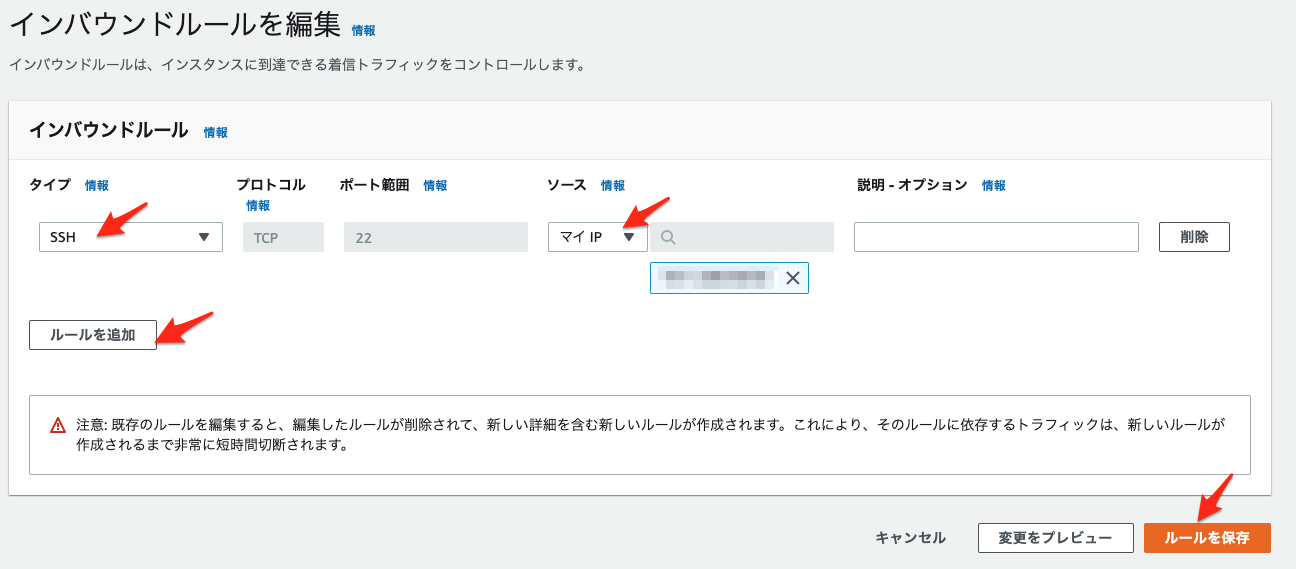

参考までに、このJupyter Notebookのアクセス元IPアドレスは以下となる。

> IPアドレスの取得に https://ifconfig.co サービスを使用します。

In [ ]:
import requests
resp = requests.get('https://ifconfig.co/json')
resp.raise_for_status()
print(resp.json()['ip'])

Security GroupのIDはStackのOutputsに記録されている。

In [ ]:
stack_desc['Outputs']

In [ ]:
security_group_id = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'CwHubSecurityGroup'][0]
security_group_id

In [ ]:
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/ec2/v2/home?region={region}#SecurityGroup:groupId={security_group_id}'.format(region=regions[0], security_group_id=security_group_id))

In [ ]:
# セキュリティグループにSSHに関する許可が含まれていれば先に進める
sg_result = !aws ec2 describe-security-groups --group-ids {security_group_id}
sg_desc = json.loads(''.join(sg_result))['SecurityGroups'][0]

assert 'IpPermissions' in sg_desc and any([ipperm['IpProtocol'] == 'tcp' and ipperm['ToPort'] <= 22 and 22 <= ipperm['FromPort'] for ipperm in sg_desc['IpPermissions']]), sg_desc['IpPermissions']

### NFSとDocker Swarmのための設定

本Notebookで作成したVMにはNFSを設定し、Docker Swarmクラスタを構築します。VMが互いに通信できるようにする必要があるため、**全てのトラフィックを自身のセキュリティグループから許可するように**設定を追加してください。

In [ ]:
print(f'以下のURLを開き、全てのトラフィックを自身のセキュリティグループ ({security_group_id}) から許可するようにルールを追加してください。')
print('https://{region}.console.aws.amazon.com/ec2/v2/home?region={region}#SecurityGroup:groupId={security_group_id}'.format(region=regions[0], security_group_id=security_group_id))

# Ansibleユーザの設定

In [ ]:
default_username = 'centos'
default_username

In [ ]:
import os

with open(os.path.join(work_dir, 'hosts'), 'w') as f:
    host_public = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'CwHubIP'][0]
    host = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'CwHubMasterPrivateIp'][0]
    f.write('{host} public_ip={host_public} ansible_ssh_user={user} ansible_ssh_private_key_file={pkpath}\n'.format(host=host,
                                                                                                                    host_public=host_public,
                                                                                                                    user=default_username,
                                                                                                                    pkpath='~/.ssh/ansible_id_rsa'))
    for host in [[o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'CwHubSlavePrivateIp{}'.format(n + 1)][0] for n in range(slave_instances)]:
        f.write('{host} ansible_ssh_user={user} ansible_ssh_private_key_file={pkpath}\n'.format(host=host,
                                                                                                user=default_username,
                                                                                                pkpath='~/.ssh/ansible_id_rsa'))
!cat {work_dir}/hosts

In [ ]:
import time

# VMのsshserverが落ち着くまで待つ...
time.sleep(30)

ssh hostkey fingerprint の確認

In [ ]:
instance_ids = [[o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'CwHubSlaveInstanceId{}'.format(n + 1)][0] for n in range(slave_instances)] + [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'CwHubMasterInstanceId']
instance_ids

In [ ]:
instance_ips = [[o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'CwHubSlavePrivateIp{}'.format(n + 1)][0] for n in range(slave_instances)] + [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'CwHubMasterPrivateIp']
instance_ips

In [ ]:
import re

all_ssh_hostkey_fingerprints = {}

for instance_id in instance_ids:
    console_output_result = !aws ec2 get-console-output --instance-id {instance_id}
    console_output = json.loads(''.join(console_output_result))
    
    console_output_lines = console_output['Output'].splitlines()
    
    ssh_hostkey_fingerprints_output = console_output_lines[
        console_output_lines.index('ec2: -----BEGIN SSH HOST KEY FINGERPRINTS-----') + 1:
        console_output_lines.index('ec2: -----END SSH HOST KEY FINGERPRINTS-----')
    ]
    
    ssh_hostkey_fingerprints = {}

    for output in ssh_hostkey_fingerprints_output:
        m = re.match(r'^ec2:\s+(\d+)\s+([^ ]+).*\((.+)\)$', output)
        algorithm = m.group(3)
        bit = m.group(1)
        fingerprint = m.group(2)
        ssh_hostkey_fingerprints[algorithm] = (bit, fingerprint)

    all_ssh_hostkey_fingerprints[instance_id] = ssh_hostkey_fingerprints

all_ssh_hostkey_fingerprints

In [ ]:
import pexpect 

for target_hostname, instance_id in zip(instance_ips, instance_ids):
    !ssh-keygen -R {target_hostname} ;:
        
    ssh_hostkey_fingerprints = all_ssh_hostkey_fingerprints[instance_id]

    fingerprint_prompt = r"\(yes/no.*\)?"
    password_prompt = r'password:'
    prompt = r'\]\$'

    p = pexpect.spawn("ssh -i ~/.ssh/ansible_id_rsa {}@{}".format(default_username, target_hostname))

    index = p.expect([fingerprint_prompt, prompt])

    if index == 0:
        msg = p.before.decode('utf-8')
        m = re.search(r'(.+) key fingerprint is', msg)
        algo = m.group(1)
        p.send('{}\n'.format(ssh_hostkey_fingerprints[algo][1]))

    p.send('exit\n')
    p.wait()

In [ ]:
!ansible -m ping -i {work_dir}/hosts all

上記のセルがエラーとなる場合は、以下のように `-vvvv` オプションをつけてどんなメッセージが流れているかを確認してみましょう。

> !ansible -vvvv -m ping -i {work_dir}/hosts all
>
> Connection timed out の場合は、先のSecurity Groupがあっているかを確認すると良い...

OK。

# Inventoryへの追記

さてこれでVMが確保できました。Inventoryにhost情報を追記して、Ansibleからアクセスできるようにしましょう。


In [ ]:
if not os.path.exists('./hosts'):
    !touch ./hosts
!cp ./hosts {work_dir}/hosts-backup

Inventoryに記述する例は以下のような感じ...

In [ ]:
print('[{}]'.format(cloudformation_stack_name))
!cat {work_dir}/hosts

Inventoryを編集する。
1. **このNotebookがあるディレクトリ と同じ階層**に `hosts` というファイルがあるので、これをクリックしてエディタを開く
2. 上記セルの出力をコピー＆ペーストする

`hosts`の変更差分を控えておく。

In [ ]:
# ./hostsに変更を加えるとこのセルを通過できる
! ! diff -u {work_dir}/hosts-backup ./hosts

`hosts` ファイルのテストを実施する。

Ansibleに上記で設定したグループ名を与えてpingモジュールを実行する。

In [ ]:
target_group = '-i ./hosts {}'.format(cloudformation_stack_name)
target_group

In [ ]:
!ansible -m ping {target_group}

これでVMの準備は完了です！

作成したVMのIPアドレス情報

マスターノード

In [ ]:
print('Private IP address: {}'.format([o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'CwHubMasterPrivateIp'][0]))
print('Public IP address: {}'.format([o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'CwHubIP'][0]))

ワーカーノード

In [ ]:
for ip in [[o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'CwHubSlavePrivateIp{}'.format(n + 1)][0] for n in range(slave_instances)]:
    print(ip)

# 後始末

一時ファイルを削除する。

In [ ]:
!rm -fr {work_dir}